In [1]:
import copy
import h5py
import numpy as np
import pandas as pd
import sys

/home1/03057/zhafen/.local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib
matplotlib.use( 'PDF' )
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.analyze_data.worldline_set as a_worldline_set

In [4]:
import linefinder.utils.presentation_constants as p_constants
import linefinder.utils.file_management as file_management
import linefinder.config as config

In [5]:
import galaxy_dive.read_data.metafile as read_metafile
import galaxy_dive.analyze_data.ahf as analyze_ahf
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.astro as astro_utils

In [6]:
import analysis_config as analysis_config

In [7]:
import colossus.cosmology.cosmology as co_cosmology

# Load Data and Set Paramters

In [8]:
file_manager = file_management.FileManager( project='CGM_fate' )

In [9]:
if sys.argv[1] == 'use_commandline':
    sim_name = sys.argv[2]
else:
    sim_name = 'm10y'

In [10]:
if sys.argv[1] == 'use_commandline':
    galdef = sys.argv[3]
else:
    galdef = '_galdefv3'

In [11]:
if sys.argv[1] == 'use_commandline':
    do_calculation = bool( int( sys.argv[4] ) )
else:
    do_calculation = False

In [12]:
print do_calculation

False


In [13]:
print( sim_name, galdef )

('m10y', '_galdefv3')


In [14]:
ahf_index = 600

In [15]:
variations = {}
for snum in analysis_config.SNUMS:
    
    variations[snum] = {}

    ptracks_tag_tail = '_CGM_snum{}'.format( snum )
    tag_tail = '{}{}'.format( ptracks_tag_tail, galdef )
    
    variations[snum] = file_manager.get_linefinder_analysis_defaults(
        tag_tail = tag_tail,
        ptracks_tag_tail = ptracks_tag_tail,
        ids_tag_tail = ptracks_tag_tail,
        sim_name = sim_name,
        ahf_index = ahf_index,
    )

In [16]:
defaults = file_manager.get_linefinder_analysis_defaults(
    sim_name = sim_name,
    tag_tail = tag_tail,
)

In [17]:
metafile_dir = file_manager.get_metafile_dir( sim_name )

In [18]:
save_file_base = '{}_CGM_redshift_mass_fraction{}'.format( sim_name, galdef )

In [19]:
output_filepath = '../data/{}.hdf5'.format( save_file_base )

In [20]:
mass_save_file_base = '{}_CGM_redshift_mass{}'.format( sim_name, galdef )

In [21]:
mass_output_filepath = '../data/{}.hdf5'.format( mass_save_file_base )

In [22]:
w_set = a_worldline_set.WorldlineSet( defaults, variations )

In [23]:
classification_list = copy.copy( p_constants.CLASSIFICATIONS_CGM_FATE )

# Actual Calculation

In [24]:
CGM_cut = w_set.values()[0].data_object.ids.data_filters['CGM']
r_min = CGM_cut['data_min']
r_max = CGM_cut['data_max']
radial_bins = np.array([ r_min, 0.5, r_max ])
# dr = 0.25
# radial_bins = np.linspace( r_min, r_max, 4 )

# Total Mass
if do_calculation:
    w_set.store_redshift_dependent_quantity(
        output_filepath = mass_output_filepath,
        max_snum = ahf_index,
        selection_routine = 'in_CGM',
        classification_list = p_constants.CLASSIFICATIONS_CGM_FATE,
        quantity_method = 'get_categories_selected_quantity_extrapolated',
        selected_quantity_method = 'get_selected_quantity_radial_bins',
        radial_bins = radial_bins,
        ptype = 'gas',
        low_memory_mode = True,
    )

In [25]:
# Fractional Mass
if do_calculation:
    w_set.store_redshift_dependent_quantity(
        output_filepath = output_filepath,
        max_snum = ahf_index,
        selection_routine = 'in_CGM',
        classification_list = p_constants.CLASSIFICATIONS_CGM_FATE,
        selected_quantity_method = 'get_selected_quantity_radial_bins',
        radial_bins = radial_bins,
        ptype = 'gas',
        low_memory_mode = True,
        normalization_category = 'is_in_CGM',
    )

In [26]:
if do_calculation:
    with h5py.File( output_filepath, 'a' ) as f:
        for key, item in w_set.items()[0][1].data_object.ptracks.data_attrs.items():
            f.attrs[key] = item

# Plot Data


### Get age of universe

In [27]:
f = h5py.File( output_filepath, 'r' )

In [28]:
g = h5py.File( mass_output_filepath, 'r' )

In [29]:
snums = f['snum'][...].copy()
snums.sort()

In [30]:
metafile_reader = read_metafile.MetafileReader( metafile_dir )

metafile_reader.get_snapshot_times()

# Get redshifts and age of universe
redshift = metafile_reader.snapshot_times.loc[snums]['redshift'].values
age_of_universe = astro_utils.age_of_universe(
    redshift,
    h=f.attrs['hubble'],
    omega_matter=f.attrs['omega_matter']
)

### Get the baryonic budgets

In [31]:
ahf_data = analyze_ahf.HaloData( data_dir=defaults['halo_data_dir'], index=defaults['ahf_index'], tag='smooth' )

In [32]:
halo_masses = ahf_data.get_mt_data(
    'Mvir',
    mt_halo_id = defaults['main_halo_id'],
)/f.attrs['hubble']

In [33]:
redshifts = ahf_data.get_mt_data( 'redshift', mt_halo_id=defaults['main_halo_id'] )

In [34]:
metafile_reader.get_used_parameters()

In [35]:
# Setup the cosmology used by the simulations                                   
sim_cosmo = {                                                                   
    'flat': True,                                                                 
    'H0' : float( metafile_reader.used_parameters['HubbleParam'] )*100.,          
    'Om0' : float( metafile_reader.used_parameters['Omega0'] ),                   
    'Ob0' : float( metafile_reader.used_parameters['OmegaBaryon'] ),              
    'sigma8' : co_cosmology.cosmologies['WMAP9']['sigma8'], # Use WMAP9 for values we don't store in our simulations explicitly.
    'ns' : co_cosmology.cosmologies['WMAP9']['ns'], # Use WMAP9 for values we don't store in our simulations explicitly.
}                                                                               
cosmo = co_cosmology.setCosmology( 'sim_cosmo', sim_cosmo ) 

In [36]:
omega_baryon = cosmo.Ob( redshifts )

In [37]:
omega_matter = cosmo.Om( redshifts )

In [38]:
m_budget = ( omega_baryon/omega_matter ) * halo_masses

In [39]:
detailed_age_of_universe = astro_utils.age_of_universe(
    redshifts,
    h=f.attrs['hubble'],
    omega_matter=f.attrs['omega_matter']
)

### Load saved data

In [40]:
def get_data_from_file( f, sl=None, sum_across=False, include_total=False ):
    
    # Load data
    data = {}
    for key in f.keys():
        if key in [ 'label', 'snum' ]:
            data[key] = f[key][...]
        else:
            if sum_across:
                data[key] = f[key][...].sum( axis=1 )
            else:
                data[key] = f[key][...][sl]
                
    if include_total:
        for key in data.keys():
            if key not in [ 'label', 'snum' ]:
                try:
                    data[None] += data[key]
                except KeyError:
                    data[None] = data[key].copy()
            
    # Get data sorted
    df = pd.DataFrame( data )
    df = df.set_index( 'snum' )
    df = df.sort_index()
    
    return df

In [41]:
def fraction_plot( ax, plotted_ind, *args, **kwargs ):

    df = get_data_from_file( f, (slice(None), plotted_ind) )

    ### Format y data

    y_datas = {}
    for key in classification_list:
        if key not in [ 'label', 'snum' ]:
            y_datas[key] = df[key].values

    ### Plot Itself

    # We don't have a data object, so we just pass None
    w_plotter = p_worldlines.WorldlinesPlotter( None, label=None )
    
    label_kwargs = {                                                            
        'xy': (0.95, 0.8),                                                     
        'xycoords': 'axes fraction',                                        
        'fontsize': 22,
        'ha' : 'right',
    }
    
#     if plotted_ind != 0:
#         twin_redshift = False
#     else:
#         twin_redshift = True

    w_plotter.plot_stacked_time_dependent_data(
        ax = ax,
        x_data = age_of_universe,
        y_datas = y_datas,
        classification_list = classification_list,
#         x_range = [ x_data.min(), np.log10( 1. + 3. ) ],
        y_label = r'f($M_{\rm CGM}$)',
        tick_redshifts = np.array( [ 0.1, 0.25, 0.4, 0.5, 0.75, 1, 1.5,  2, 2.5, 3, 4, 5, ] ),
        time_x_axis = True,
        twin_redshift = False,
        label_kwargs = label_kwargs,
        hubble = f.attrs['hubble'],
        omega_matter = f.attrs['omega_matter'],
        x_range = [ age_of_universe.min(), age_of_universe.max() ],
        *args, **kwargs
    )
    
    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[-1].set_verticalalignment( 'top' )
        
    # Adjust tick parameters
    ax.tick_params( direction='in', which='bottom', top=True, )
    
    # Hide labels
#     if plotted_ind != 2:
#         ax.tick_params( labelbottom = False )
#     if plotted_ind == 0:
#         ax.tick_params( labeltop = True )

In [42]:
# For the plot label
dr = radial_bins[1] - radial_bins[0]

def plot_label( r_start, r_end ):
    return r'{}'.format( r_start ) + r'$<R/R_{{\rm vir}}<$' + r'{}'.format(  r_end )

File saved at /home1/03057/zhafen/papers/CGM_fate/figures/m10y_CGM_redshift_mass_fraction_galdefv3.pdf


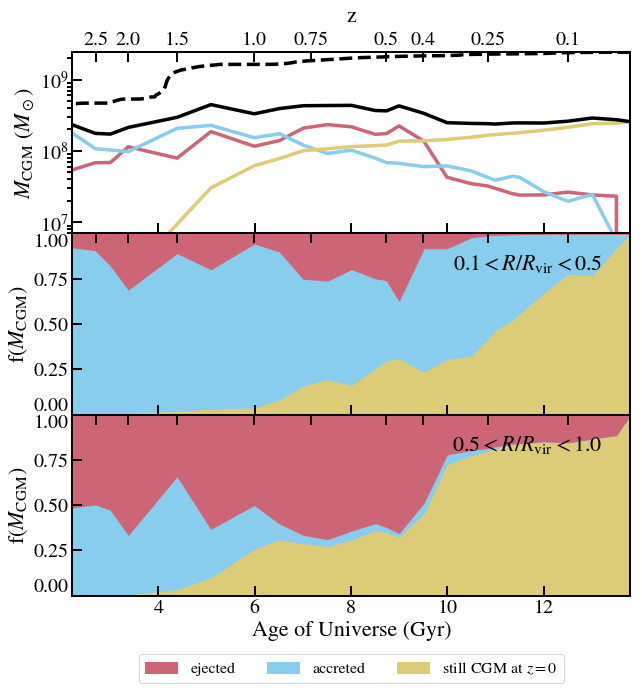

In [46]:
fig = plt.figure( figsize=(10,10) )
main_ax = plt.gca()

gs = gridspec.GridSpec(3, 1)

ax0 = plt.subplot( gs[0,0])

gs.update(wspace=0.025, hspace=0.0001)

# Setup y ranges
y_mins = {
    'm10y': 7e6,
    'm11q': 7e7,
    'm12i': 4e8,
}

df = get_data_from_file( g, sum_across=True, include_total=True )

y_datas = {}
for key in df.keys():
    if key not in [ 'label', 'snum' ]:
        y_datas[key] = df[key].values

plotted_total_categories = copy.copy( p_constants.CLASSIFICATIONS_CGM_FATE )
plotted_total_categories.append( None )

# Make the plots
for classification in plotted_total_categories:
    ax0.plot(
        age_of_universe,
        y_datas[classification],
        color = p_constants.CLASSIFICATION_COLORS_B[classification],
        linewidth = 3.5,
    )
    
# Plot baryon budget
ax0.plot(
    detailed_age_of_universe,
    m_budget,
    linewidth = 3.5,
    linestyle = '--',
    color = 'k',
)

# Loop through again to tweak axes
for i in range( len(radial_bins ) ):
    
    ax = plt.subplot( gs[i,0] )
     
    # First row tweaks
    if ax.is_first_row():
        ax.set_yscale( 'log' )
        ax.set_ylabel( r'$M_{\rm CGM}$ $(M_\odot)$', fontsize=22 )               
        
    # Tweak limits
    ax.set_xlim( age_of_universe.min(), age_of_universe.max() )
    ax.set_ylim( y_mins[sim_name], m_budget.max() )

    # Add a second axis for plotting                                    
    ax2 = plotting.add_redshift_to_axis(
        ax,
        hubble = f.attrs['hubble'],
        omega_matter = f.attrs['omega_matter'],
    )                            
    if ax.is_first_row():
        ax2.set_xlabel( r'z', fontsize=22, labelpad=10 )  
    
        # Change tick orientation
    ax.tick_params( direction='in' )
    ax2.tick_params( direction='in' )
    
    # Hide overlapping labels
    if not ax.is_first_row():
        ax2.xaxis.set_ticklabels([])
    if not ax.is_last_col():
        ax.xaxis.set_ticklabels([])
    
    # Make fraction plots. Has to be done here for some stupid reason.
    # Totally not frustrated. Nope.
    if not ax.is_first_row():
            
        fraction_plot(
            ax,
            i-1,
            add_legend = ax.is_last_row(),
            legend_kwargs = {
                'loc' : 'center',
                'bbox_to_anchor' : ( 0.5, -0.4 ),
                'ncol' : 4,
            },
            label = plot_label( radial_bins[i-1], radial_bins[i] ),
        )
            
save_file = '{}.pdf'.format( save_file_base )

plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

# Analysis

In [ ]:
import os

import galaxy_dive.utils.utilities as utilities

import py2tex.py2tex as py2tex

In [ ]:
tex_filepath = os.path.join( file_manager.project_parameters['project_dir'], 'variables.tex' )

In [ ]:
tex_file = py2tex.TeXVariableFile( tex_filepath )